# **1. Import Libraries and Data**
----

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.1 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pp
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2024-10-06 03:55:55--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  2.29MB/s    in 0.4s    

2024-10-06 03:55:56 (2.29 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# **2. Define Data Preparing Function**
---

In [5]:
def load_data():
    movies_df = pd.read_csv('ml-latest-small/movies.csv', index_col='movieId')
    ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
    return movies_df, ratings_df

In [6]:
def preprocess_data(ratings_df):
    ratings_df = ratings_df[ratings_df['rating'] >= 3]
    train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=101)

    le_user = pp.LabelEncoder()
    le_item = pp.LabelEncoder()
    train_df['user_id_idx'] = le_user.fit_transform(train_df['userId'].values)
    train_df['item_id_idx'] = le_item.fit_transform(train_df['movieId'].values)

    train_user_ids = train_df['userId'].unique()
    train_item_ids = train_df['movieId'].unique()
    test_df = test_df[
        (test_df['userId'].isin(train_user_ids)) & (test_df['movieId'].isin(train_item_ids))
    ]
    test_df['user_id_idx'] = le_user.transform(test_df['userId'].values)
    test_df['item_id_idx'] = le_item.transform(test_df['movieId'].values)

    n_users = train_df['user_id_idx'].nunique()
    n_items = train_df['item_id_idx'].nunique()

    return train_df, test_df, n_users, n_items, le_user, le_item

# **3. Define the Model Architecture**


---



In [7]:
class LightGCNConv(MessagePassing):
    def __init__(self, **kwargs):
        super().__init__(aggr='add')

    def forward(self, x, edge_index):
        from_, to_ = edge_index
        deg = degree(to_, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

In [8]:
class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, latent_dim, num_layers):
        super(LightGCN, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.latent_dim = latent_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(num_users + num_items, latent_dim)
        self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

        self.init_parameters()

    def init_parameters(self):
        nn.init.normal_(self.embedding.weight, std=0.1)

    def forward(self, edge_index):
        emb0 = self.embedding.weight
        embs = [emb0]

        emb = emb0
        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        out = torch.mean(torch.stack(embs, dim=0), dim=0)

        return emb0, out

    def encode_minibatch(self, users, pos_items, neg_items, edge_index):
        emb0, out = self(edge_index)
        return (
            out[users],
            out[pos_items],
            out[neg_items],
            emb0[users],
            emb0[pos_items],
            emb0[neg_items]
        )

# **4. Define Loss and Metrics**


---



In [9]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0, pos_emb0, neg_emb0):
    reg_loss = (1 / 2) * (
        user_emb0.norm().pow(2) +
        pos_emb0.norm().pow(2) +
        neg_emb0.norm().pow(2)
    ) / float(len(users))

    pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
    neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

    bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

    return bpr_loss, reg_loss

In [10]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())
    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts, 0, 1))

    i = torch.stack((
        torch.LongTensor(train_data['user_id_idx'].values),
        torch.LongTensor(train_data['item_id_idx'].values)
    ))
    v = torch.ones((len(train_data)), dtype=torch.float64)
    interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items)).to_dense().to(device)

    relevance_score = torch.mul(relevance_score, (1 - interactions_t))

    topk_relevance_indices = torch.topk(relevance_score, K).indices
    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(), columns=['top_indx_'+str(x+1) for x in range(K)])
    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

    test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    metrics_df = pd.merge(test_interacted_items, topk_relevance_indices_df, how='left', left_on='user_id_idx', right_on=['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]

    metrics_df['recall'] = metrics_df.apply(lambda x: len(x['intrsctn_itm'])/len(x['item_id_idx']), axis=1)
    metrics_df['precision'] = metrics_df.apply(lambda x: len(x['intrsctn_itm'])/K, axis=1)
    metrics_df['accuracy'] = metrics_df.apply(lambda x: sum([1 for item in x['intrsctn_itm'] if item in x['item_id_idx']]) / len(x['intrsctn_itm']) if len(x['intrsctn_itm']) > 0 else 0.0, axis=1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean(), metrics_df['accuracy'].mean()

# **5. Define Data Loader**


---



In [11]:
def data_loader(data, batch_size, n_usr, n_itm):
    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    indices = [x for x in range(n_usr)]

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users, columns=['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how='right', left_on='user_id_idx', right_on='users')
    pos_items = interected_items_df['item_id_idx'].apply(lambda x: random.choice(x) if isinstance(x, list) else x).values
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x) if isinstance(x, list) else sample_neg([])).values

    return (
        torch.LongTensor(list(users)).to(device),
        torch.LongTensor(list(pos_items)).to(device) + n_usr,
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )

# **5. Training and Evaluation**
---

In [12]:
def train_and_eval(model, optimizer, train_df, test_df, n_users, n_items, train_edge_index, EPOCHS, BATCH_SIZE, DECAY, K):
    loss_list_epoch = []
    bpr_loss_list_epoch = []
    reg_loss_list_epoch = []
    recall_list = []
    precision_list = []
    accuracy_list = []

    for epoch in tqdm(range(EPOCHS)):
        n_batch = int(len(train_df)/BATCH_SIZE)

        final_loss_list = []
        bpr_loss_list = []
        reg_loss_list = []

        model.train()
        for batch_idx in range(n_batch):
            optimizer.zero_grad()

            users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
            users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

            bpr_loss, reg_loss = compute_bpr_loss(
                users, users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0
            )
            reg_loss = DECAY * reg_loss
            final_loss = bpr_loss + reg_loss

            final_loss.backward()
            optimizer.step()

            final_loss_list.append(final_loss.item())
            bpr_loss_list.append(bpr_loss.item())
            reg_loss_list.append(reg_loss.item())

        model.eval()
        with torch.no_grad():
            _, out = model(train_edge_index)
            final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
            test_topK_recall, test_topK_precision, test_accuracy = get_metrics(
                final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K
            )

        loss_list_epoch.append(round(np.mean(final_loss_list), 4))
        bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list), 4))
        reg_loss_list_epoch.append(round(np.mean(reg_loss_list), 4))

        recall_list.append(round(test_topK_recall, 4))
        precision_list.append(round(test_topK_precision, 4))
        accuracy_list.append(round(test_accuracy, 4))

    return (
        loss_list_epoch,
        bpr_loss_list_epoch,
        reg_loss_list_epoch,
        recall_list,
        precision_list,
        accuracy_list
    )

In [13]:
def plot_metrics(loss_list, bpr_loss_list, reg_loss_list, recall_list, precision_list, accuracy_list, EPOCHS):
    epoch_list = [(i + 1) for i in range(EPOCHS)]

    plt.figure(figsize=(14, 6))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epoch_list, loss_list, label='Total Training Loss')
    plt.plot(epoch_list, bpr_loss_list, label='BPR Training Loss')
    plt.plot(epoch_list, reg_loss_list, label='Reg Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Losses')

    # Plot metrics
    plt.subplot(1, 2, 2)
    plt.plot(epoch_list, recall_list, label='Recall')
    plt.plot(epoch_list, precision_list, label='Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.legend()
    plt.title('Evaluation Metrics')

    plt.tight_layout()
    plt.show()

    print("Max Precision:", max(precision_list))
    print("Max Recall:", max(recall_list))
    print("Final Accuracy:", accuracy_list[-1])
    print("Max Accuracy:", max(accuracy_list))

# **6. Define Model Functions**
---

In [14]:
def create_edge_index(train_df, n_users):
    u_t = torch.LongTensor(train_df.user_id_idx)
    i_t = torch.LongTensor(train_df.item_id_idx) + n_users
    train_edge_index = torch.stack((
        torch.cat([u_t, i_t]),
        torch.cat([i_t, u_t])
    )).to(device)
    return train_edge_index

In [15]:
def update_embeddings(model, user_id, item_id, rating, n_users, learning_rate=0.01):
    user_embedding = model.embedding.weight[user_id]
    item_embedding = model.embedding.weight[item_id + n_users]

    adjustment = (rating - user_embedding.dot(item_embedding)) * learning_rate

    with torch.no_grad():
        model.embedding.weight[user_id] += adjustment * item_embedding
        model.embedding.weight[item_id + n_users] += adjustment * user_embedding


def add_new_user_embedding(model, n_users):
    with torch.no_grad():
        new_embedding = torch.randn(1, model.embedding.weight.size(1), device=model.embedding.weight.device)
        model.embedding.weight = nn.Parameter(torch.cat([model.embedding.weight, new_embedding], dim=0))
    return n_users + 1

In [16]:
def get_top_recommendations(user_id, selected_genres, model, movies_df, ratings_df, le_user, le_item, n_users, top_n=10):
    filtered_movies = movies_df[movies_df['genres'].apply(lambda x: any(genre in x for genre in selected_genres))]

    with torch.no_grad():
        all_embeddings = model.embedding.weight

    if user_id not in le_user.classes_:
        print(f"New user detected (ID: {user_id}). Adding to the model.")
        n_users = add_new_user_embedding(model, n_users)
        le_user.classes_ = np.append(le_user.classes_, user_id)
        user_idx = len(le_user.classes_) - 1

        # Add the new user to the ratings dataframe
        new_user_df = pd.DataFrame({'userId': [user_id], 'user_id_idx': [user_idx]})
        ratings_df = pd.concat([ratings_df, new_user_df], ignore_index=True)
    else:
        user_idx = le_user.transform([user_id])[0]

    user_embedding = all_embeddings[user_idx]
    item_embeddings = all_embeddings[n_users:n_users + len(movies_df)]

    similarities = torch.cosine_similarity(user_embedding.unsqueeze(0), item_embeddings)
    top_indices = torch.argsort(similarities, descending=True)[:len(filtered_movies)]

    recommended_movie_ids = le_item.inverse_transform(top_indices.cpu().numpy())
    recommended_movie_ids = [movie_id for movie_id in recommended_movie_ids if movie_id in filtered_movies.index]
    recommendations = filtered_movies.loc[recommended_movie_ids]
    recommendations['matching_genres'] = recommendations['genres'].apply(lambda x: sum(genre in x for genre in selected_genres))
    recommendations = recommendations.sort_values(by='matching_genres', ascending=False)

    return recommendations.head(top_n)[['title', 'genres']], ratings_df

In [17]:
def update_model_with_new_rating(model, ratings_df, user_id, movie_id, rating, n_users, le_user, le_item):
    if user_id not in le_user.classes_:
        print(f"New user detected (ID: {user_id}). Adding to the model.")
        n_users = add_new_user_embedding(model, n_users)
        le_user.classes_ = np.append(le_user.classes_, user_id)
        user_idx = len(le_user.classes_) - 1
    else:
        user_idx = le_user.transform([user_id])[0]

    if movie_id not in le_item.classes_:
        print(f"New movie detected (ID: {movie_id}). Adding to the model.")
        with torch.no_grad():
            new_item_embedding = torch.randn(1, model.embedding.weight.size(1), device=model.embedding.weight.device)
            model.embedding.weight = nn.Parameter(torch.cat([model.embedding.weight, new_item_embedding], dim=0))
        le_item.classes_ = np.append(le_item.classes_, movie_id)
        item_idx = len(le_item.classes_) - 1
    else:
        item_idx = le_item.transform([movie_id])[0]

    # Update embeddings
    update_embeddings(model, user_idx, item_idx, rating, n_users)

    # Add new rating to the dataframe
    new_rating = pd.DataFrame({
        'userId': [user_id],
        'movieId': [movie_id],
        'rating': [rating],
        'timestamp': [pd.Timestamp.now().timestamp()],
        'user_id_idx': [user_idx],
        'item_id_idx': [item_idx]
    })
    ratings_df = pd.concat([ratings_df, new_rating], ignore_index=True)

    return model, ratings_df, n_users

# **7. Main Function**
---

100%|██████████| 5/5 [01:17<00:00, 15.54s/it]


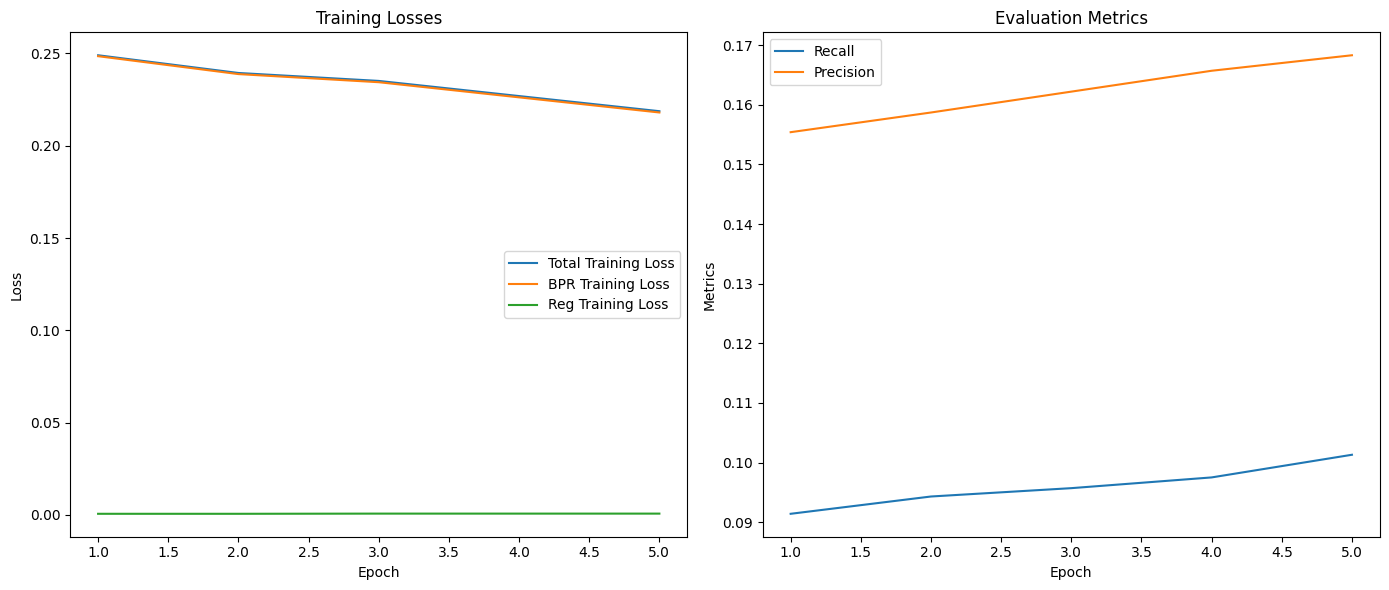

Max Precision: 0.1683
Max Recall: 0.1013
Final Accuracy: 0.6304
Max Accuracy: 0.6304


In [20]:
def main():
    # Load and preprocess data
    movies_df, ratings_df = load_data()
    train_df, test_df, n_users, n_items, le_user, le_item = preprocess_data(ratings_df)
    train_edge_index = create_edge_index(train_df, n_users)

    # Model parameters
    latent_dim = 64
    n_layers = 3
    EPOCHS = 50
    BATCH_SIZE = 1024
    DECAY = 0.0001
    LR = 0.001
    K = 10

    # Initialize and train the model
    model = LightGCN(n_users, n_items, latent_dim, n_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    loss_list, bpr_loss_list, reg_loss_list, recall_list, precision_list, accuracy_list = train_and_eval(model, optimizer, train_df, test_df, n_users, n_items, train_edge_index, EPOCHS, BATCH_SIZE, DECAY, K)
    plot_metrics(loss_list, bpr_loss_list, reg_loss_list, recall_list, precision_list, accuracy_list, EPOCHS)

if __name__ == "__main__":
    main()

In [23]:
def main():
    # Load and preprocess data
    movies_df, ratings_df = load_data()
    train_df, test_df, n_users, n_items, le_user, le_item = preprocess_data(ratings_df)
    train_edge_index = create_edge_index(train_df, n_users)

    # Model parameters
    latent_dim = 64
    n_layers = 3
    EPOCHS = 50
    BATCH_SIZE = 1024
    DECAY = 0.0001
    LR = 0.001
    K = 10

    # Initialize and train the model
    model = LightGCN(n_users, n_items, latent_dim, n_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    train_and_eval(model, optimizer, train_df, test_df, n_users, n_items, train_edge_index, EPOCHS, BATCH_SIZE, DECAY, K)

    while True:
        user_id = int(input("Enter your user ID (or -1 to exit): "))
        if user_id == -1:
            break

        available_genres = list(set('|'.join(movies_df['genres']).split('|')))
        print("Available genres:", available_genres)
        selected_genres = input("Enter preferred genres (comma-separated): ").split(',')

        recommendations, ratings_df = get_top_recommendations(user_id, selected_genres, model, movies_df, ratings_df, le_user, le_item, n_users)
        print("Top Recommendations:")
        print(recommendations)

        movie_id = int(input("Enter the movie ID you want to rate (-1 to skip): "))
        if movie_id != -1:
            rating = float(input("Enter your rating (0-5): "))
            model, ratings_df, n_users = update_model_with_new_rating(model, ratings_df, user_id, movie_id, rating, n_users, le_user, le_item)
            print("Rating added and model updated.")

    print("Thank you for using the recommendation system!")

if __name__ == "__main__":
    main()

Enter your user ID (or -1 to exit): -1
Thank you for using the recommendation system!
